In [46]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [47]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
import seaborn as sns
import pandas as pd
from matplotlib.pyplot import cm

In this notebook we consider a control protocol consisting of an initial lockdown, which is then partly released. For our numerical study we generate synthetic data using the stochastic SIIR model.

While we use the UK age structure and contact matrix, we used here simulated data.

**Summary:**

1. We load the age structure and contact matrix for Denmark. The contact matrix is generally given as
\begin{equation}
    C = C_{H} + C_{W} + C_{S} + C_{O},
\end{equation}
where the four terms denote the number of contacts at home, work, school, and all other remaining contacts.
2. We define the other model parameters of the SIIR model **(these are not fitted to any real data)**.
3. We define a "lockdown-protocol":
    Withing a certain time range, a lockdown is imposed (shcool closure). The contact matrix is reduced to 
    \begin{equation}
        C = C_{H} 
     \end{equation} 

We want to see an impact if the school reopen, when do we see a change in the number of people infected ? Which age group is the most infected ?


## Get the contact Matrices for UK

In [48]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('../../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [80]:
df1= pd.DataFrame({'Female':aF,  'Age':['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90-94','95-99','100+'], 'Sex':['F']*21})
df2 = pd.DataFrame({'Male':aM,  'Age':['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90-94','95-99','100+'], 'Sex':['M']*21})
df3 = pd.concat([df1, df2], join='inner')
df3['number'] = np.concatenate((aF,aM))

C is the sum of contributions from contacts at home, workplace, schools and all other public spheres. Using superscripts $H$, $W$, $S$ and $O$ for each of these, we write the contact matrix as
$$
C_{ij} = C^H_{ij} + C^W_{ij} + C^S_{ij} + C^O_{ij}
$$

We read in these contact matrices from the data sets provided in the paper *Projecting social contact matrices in 152 countries using contact surveys and demographic data* by Prem et al, sum them to obtain the total contact matrix. We also read in the age distribution of UK obtained from the *Population pyramid* website.

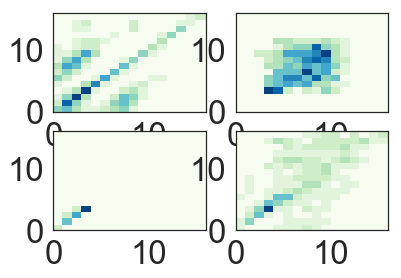

In [81]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.UK()

# By default, home, work, school, and others contribute to the contact matrix
C = CH + CW + CS + CO

# Illustrate the individual contact matrices:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

## Covid19 data 

In [82]:
# Get the latest data from Johns Hopkins University
!git clone https://github.com/CSSEGISandData/COVID-19

fatal: destination path 'COVID-19' already exists and is not an empty directory.


In [83]:
cases = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,998,1004,1029,1050,1076,1099,1122,1137,1143,1164
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,762,763,763,763,763,764,764,764,765,844
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,69,70,70,71,74,81,84,86,86,86


In [84]:
deaths = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths.shape

(266, 137)

In [85]:
cases[cases['Country/Region']=='United Kingdom']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20
217,Bermuda,United Kingdom,32.3078,-64.7505,0,0,0,0,0,0,...,133,133,139,139,140,140,140,140,141,141
218,Cayman Islands,United Kingdom,19.3133,-81.2546,0,0,0,0,0,0,...,129,134,137,140,140,141,141,141,150,151
219,Channel Islands,United Kingdom,49.3723,-2.3644,0,0,0,0,0,0,...,558,559,559,560,560,560,560,560,560,560
220,Gibraltar,United Kingdom,36.1408,-5.3536,0,0,0,0,0,0,...,154,154,154,157,158,161,169,170,170,172
221,Isle of Man,United Kingdom,54.2361,-4.5481,0,0,0,0,0,0,...,336,336,336,336,336,336,336,336,336,336
222,Montserrat,United Kingdom,16.7425,-62.1874,0,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,11
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,259559,261184,265227,267240,269127,271222,272826,274762,276332,277985
248,Anguilla,United Kingdom,18.2206,-63.0686,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
249,British Virgin Islands,United Kingdom,18.4207,-64.6400,0,0,0,0,0,0,...,8,8,8,8,8,8,8,8,8,8
250,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,0,0,0,0,0,0,...,12,12,12,12,12,12,12,12,12,12


In [86]:
cols = cases.columns.tolist() 
case = cases.loc[223,][4:]
death = deaths.loc[223,][4:]

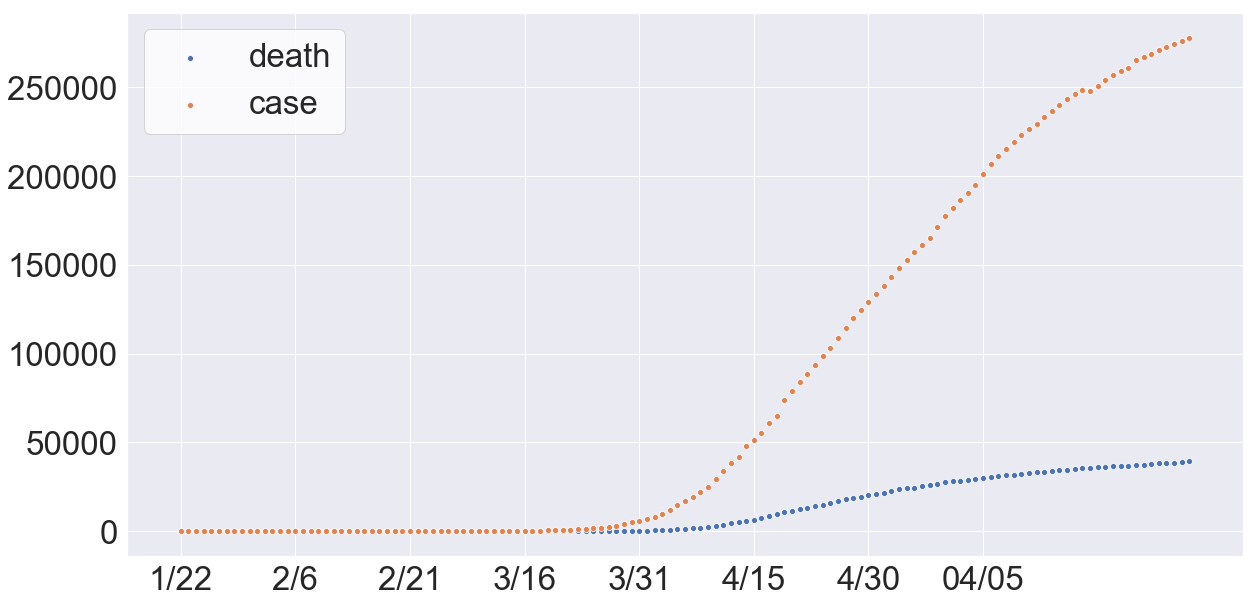

In [87]:
plt.figure(figsize=(20,10))
sns.set(font_scale=3)  # crazy big
plt.legend(fontsize='x-large', title_fontsize='1000')
sns.set_style(style='white')
plt.legend(fontsize='x-large', title_fontsize='10000')
sns.scatterplot(np.arange(len(death)),death, label='death');
sns.scatterplot(x=np.arange(len(case)), y=case, label='case');
plt.ylabel('')
plt.title('')
plt.xticks(np.arange(0, 115,15), ('1/22', '2/6', '2/21', '3/16', '3/31', '4/15','4/30', '04/05'));
plt.savefig('UKcovid19.png', format='png', dpi=200)

## Deterministic SIR model for UK

Using this code : https://github.com/rajeshrinet/pyross/blob/master/examples/deterministic/ex03-age-structured-SIR-for-India.ipynb

Assume that the population has been partitioned into  $i=1,\ldots, M$ age groups and that we have available the $M\times M$ contact matrix $C_{ij}$.  We assume all initial cases are symptomatic, and remain so.

See SIR model : pyross/deterministic.pyx

In [131]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

The infection parameter $\beta$ is unknown, so we fit it to the case data till 25th March. 

In [132]:
## Parameters of the model (random)

beta  = 0.01546692 # infection rate assumed intrinsic to the pathogen
gIa   = 1./7             # recovery rate of asymptomatic infectives (7 days)
gIs   = 1./7             # recovery rate of symptomatic infectives 
alpha = 0.               # fraction of asymptomatic infectives
fsa   = 1             # the self-isolation parameter   
    
    
# initial conditions    
Is_0 = np.zeros((M));  Is_0[0:15]=200
Ia_0 = np.zeros((M)) # no asymptomatic infectives
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)

In [133]:
# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (1.264513426078052+0j)


In [134]:
# instantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)

In [135]:
# the contact structure is independent of time 
def contactMatrix(t):
    return C

In [136]:
# time_points to solve the ode (using odeint) Ti = 0 by default 
Tf=350;  Nf=3500;  #Tf is the final day np.linspace(Ti, Tf, Nf) 

In [137]:
# run model
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

In [138]:
data['X'].shape # 48 because 16 groups * 4 equations 

(3500, 48)

In [139]:
t = data['t']; IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i]

In [140]:
index_max = np.argmax(IC)

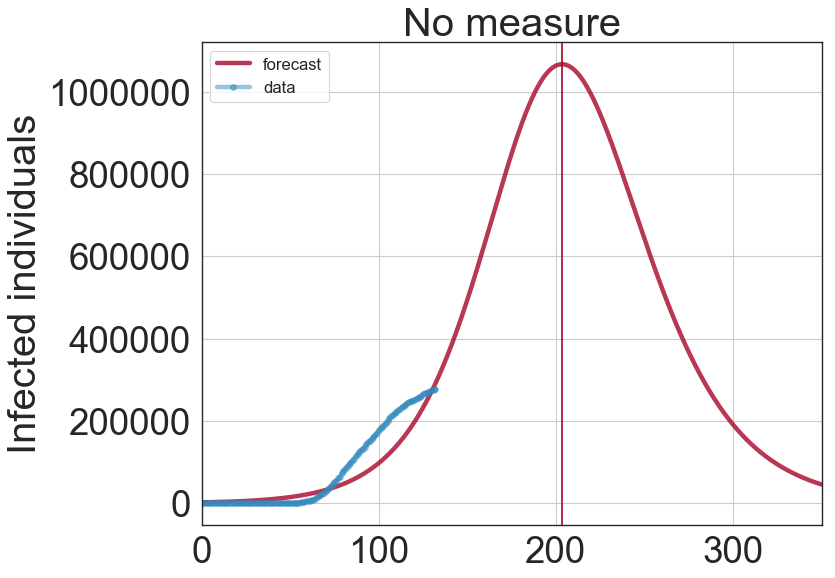

In [142]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.axvline(x=index_max/10, ymin=0, ymax=175000, color='#A60628')
day, cases = np.array(np.arange(1,Tf)), np.array(case[0:Tf])
plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=5, label='data', alpha=0.5)
plt.legend(fontsize=15, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals');
plt.title('No measure');
plt.savefig('FullmatrixC.png', format='png', dpi=200)

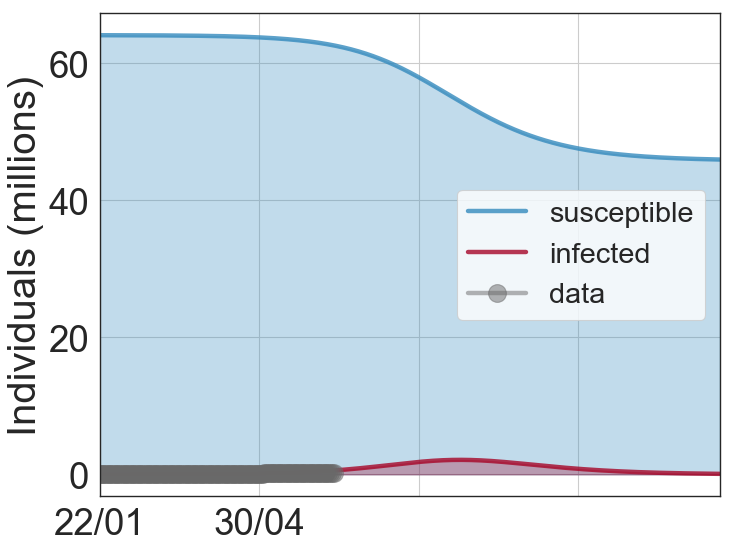

In [143]:
SC  = np.zeros((Nf))
for i in range(M):
        SC += data.get('X')[:,0*M+i]
        IC += data.get('X')[:,2*M+i]

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, SC*10**(-6), '-', lw=4, color='#348ABD', label='susceptible', alpha=0.8,)
plt.fill_between(t, 0, SC*10**(-6), color="#348ABD", alpha=0.3)

plt.plot(t, IC*10**(-6), '-', lw=4, color='#A60628', label='infected', alpha=0.8)
plt.fill_between(t, 0, IC*10**(-6), color="#A60628", alpha=0.3)


plt.plot(cases*10**(-6), 'ro-', lw=4, color='dimgrey', ms=16, label='data', alpha=0.5)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Individuals (millions)')
plt.xticks(np.arange(0, Tf, 90), ('22/01', '30/04'  ));
plt.savefig('C-SIRNomesure.png', format='png', dpi=200)

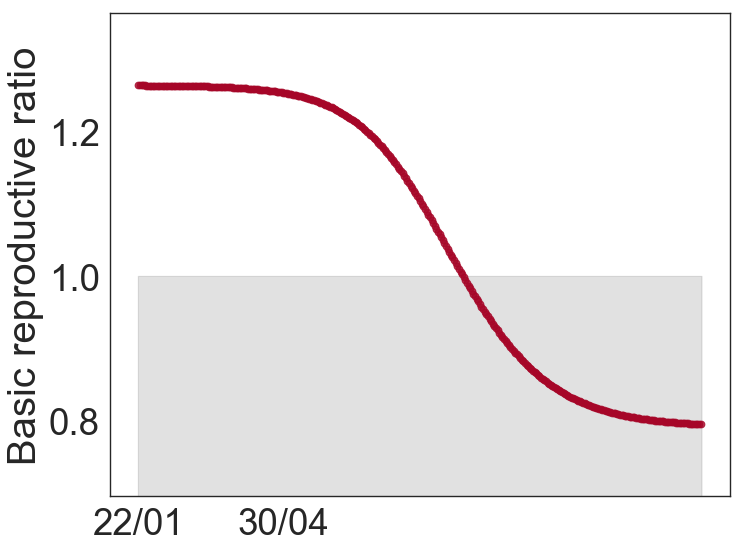

In [144]:
# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))
xind=[np.argsort(IC)[-1]]

rr = np.zeros((Tf))

for tt in range(Tf):
    Si = np.array((data['X'][tt*10,0:M])).flatten()
    for i in range(M):
        for j in range(M):
            L0[i,j]=C[i,j]*Si[i]/Ni[j]
    L[0:M, 0:M]     =    alpha*beta/gIs*L0
    L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
    L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
    L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0

    rr[tt] = np.real(np.max(np.linalg.eigvals(L)))
    
    
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t[::10], rr, 'o', lw=4, color='#A60628', label='suscetible', alpha=0.8,)
plt.fill_between(t, 0, t*0+1, color="dimgrey", alpha=0.2); plt.ylabel('Basic reproductive ratio')
plt.ylim(np.min(rr)-.1, np.max(rr)+.1)
plt.xticks(np.arange(0, Tf, 90), ('22/01', '30/04'  ));
plt.savefig('C-R0Nomesure.png', format='png', dpi=200)

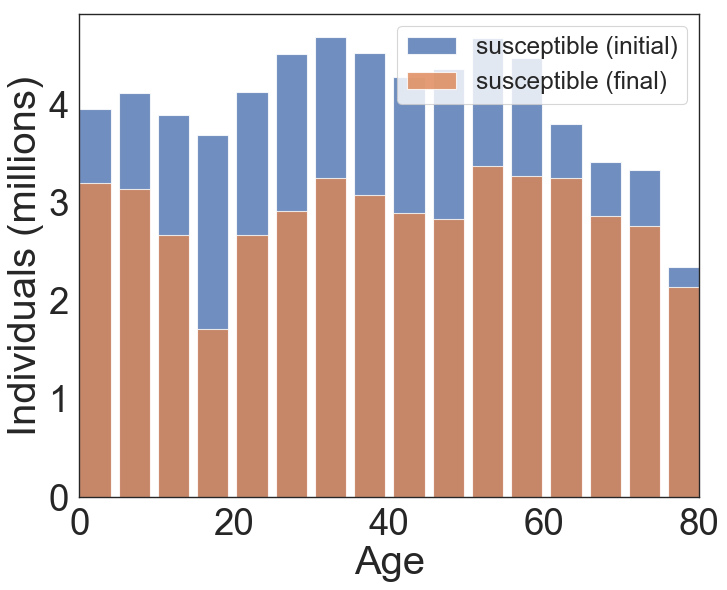

In [145]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.bar(np.arange(16),data.get('X')[0,0:M]*10**(-6),   label='susceptible (initial)', alpha=0.8)
plt.bar(np.arange(16),data.get('X')[-1,0:M]*10**(-6),   label='susceptible (final)', alpha=0.8)

plt.xticks(np.arange(-0.4, 16.45, 3.95), ('0', '20', '40', '60', '80'));
plt.xlim(-0.45, 15.45); plt.ylabel('Individuals (millions)'); plt.xlabel('Age')
plt.legend(fontsize=22); plt.axis('tight')
plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('C-indsusNomesure.png', format='png', dpi=200)

### Mortality 

We extract the number of susceptibles remaining in each age group, and the difference with the initial number of susceptibles is the total number that are infected. We multiply this with mortality data from China to obtain mortality estimates.



In [146]:
MM = np.array((0,0,.0,1,1,1,1,1,1,3.5,3.5,3.5,3.5,6,6,14.2))  

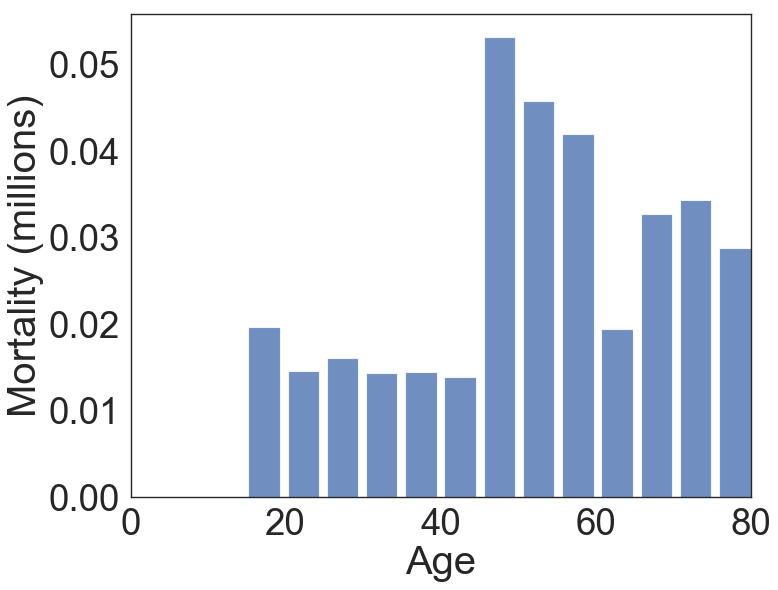

In [147]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

m1 = .01*MM*(data.get('X')[0,0:M]-data['X'][-1,0:M])
plt.bar(np.arange(16),m1*10**(-6),   label='susceptible (final)', alpha=0.8)

plt.axis('tight'); plt.xticks(np.arange(-0.4, 16.45, 3.95), ('0', '20', '40', '60', '80'));
plt.xlim(-0.45, 15.45); plt.ylabel('Mortality (millions)'); plt.xlabel('Age')

plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('C-mortalityNomesure.png', format='png', dpi=200)


## Non Pharmaceutical intervention

# School closure

Friday, March 20 in UK


###  Change the day to open again schools

In [148]:
dayclosure = 58
dayopen1 = dayclosure+60
dayopen2 = dayclosure+80
dayopen3 = dayclosure+200


In [149]:
model = pyross.deterministic.SIR(parameters, M, Ni)

In [150]:
# the contact matrix is time-dependent
def contactMatrix1(t):
    if t<dayclosure:
        xx = C
    elif dayclosure<=t<dayopen1:
        xx = CH
    else:
        xx = C
    return xx

def contactMatrix2(t):
    if t<dayclosure:
        xx = C
    elif dayclosure<=t<dayopen2:
        xx = CH
    else:
        xx = C
    return xx


def contactMatrix3(t):
    if t<dayclosure:
        xx = C
    elif dayclosure<=t<dayopen3:
        xx = CH
    else:
        xx = C
    return xx


In [151]:
# start simulation
Tf=1000;  Nf=3500 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix1, Tf, Nf)
data2=model.simulate(S_0, Ia_0, Is_0, contactMatrix2, Tf, Nf)
data3=model.simulate(S_0, Ia_0, Is_0, contactMatrix3, Tf, Nf)

In [152]:
t1 = data['t']; IC1  = np.zeros((Nf))
for i in range(M):
        IC1 += data['X'][:,2*M+i]
        
t2 = data2['t']; IC2 = np.zeros((Nf))
for i in range(M):
        IC2 += data2['X'][:,2*M+i]
        
        
t3 = data3['t']; IC3= np.zeros((Nf))
for i in range(M):
        IC3 += data3['X'][:,2*M+i]

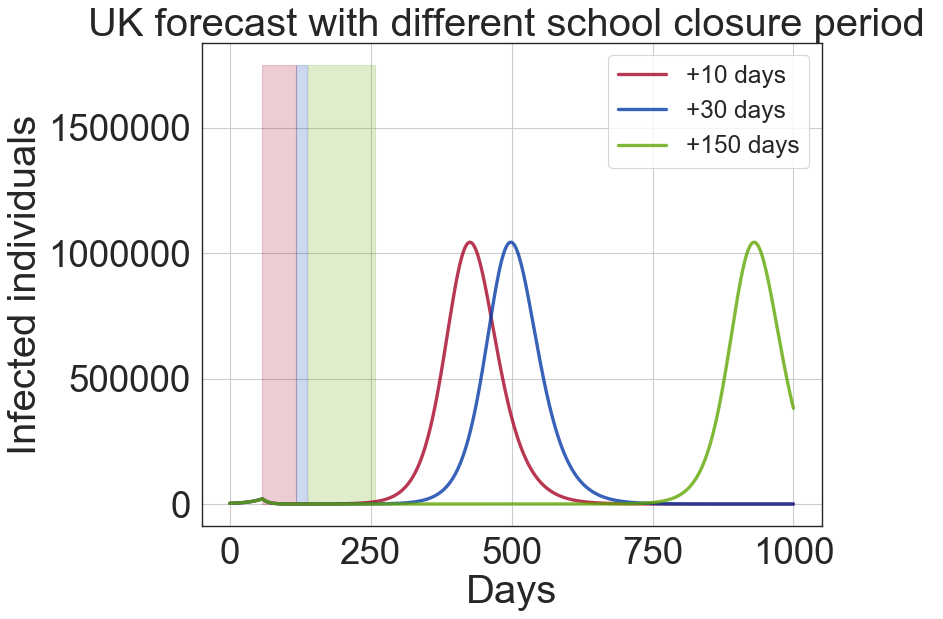

In [153]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 6})
plt.plot(t1, IC1, '-', lw=3, color='#A60628', label='+10 days', alpha=0.8)
plt.fill_between(np.arange(dayclosure,dayopen1), 0, 1750000, color="#A60628", alpha=0.2)

plt.plot(t2, IC2, '-', lw=3, color='#063ba6', label='+30 days', alpha=0.8)
plt.fill_between(np.arange(dayopen1,dayopen2), 0, 1750000, color="#063ba6", alpha=0.2)

plt.plot(t3, IC3, '-', lw=3, color='#61a606', label='+150 days', alpha=0.8)
plt.fill_between(np.arange(dayopen2,dayopen3), 0, 1750000, color="#61a606", alpha=0.2)

plt.legend(fontsize=22); plt.axis('tight'); plt.grid() 
plt.ylabel('Infected individuals');
plt.xlabel('Days')
plt.title('UK forecast with different school closure period ');
plt.savefig('UK-forecast-with-different-school-closure-period.png', format='png', dpi=200)

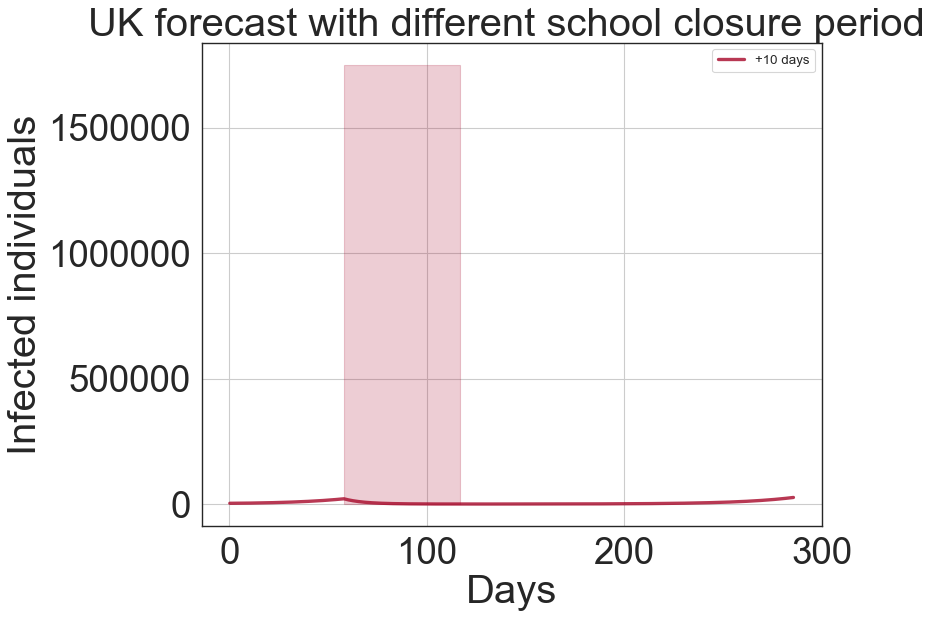

In [162]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 6})
plt.plot(t1[1:1000], IC1[1:1000], '-', lw=3, color='#A60628', label='+10 days', alpha=0.8)
plt.fill_between(np.arange(dayclosure,dayopen1), 0, 1750000, color="#A60628", alpha=0.2)


plt.legend(fontsize=12); plt.axis('tight'); plt.grid() 
plt.ylabel('Infected individuals');
plt.xlabel('Days')
plt.title('UK forecast with different school closure period ');
plt.savefig('UK-forecast-with-different-school-closure-period.png', format='png', dpi=200)

### Look at the numbers per age range

In [163]:
S1= np.zeros((Nf, M))
S2 = np.zeros((Nf, M))
S3 = np.zeros((Nf, M))
I1 = np.zeros((Nf, M))
I2 = np.zeros((Nf, M))
I3 = np.zeros((Nf, M))

for i in range(M):
        S1[:,i] = data.get('X')[:,0*M+i]
        I1[:,i] = data.get('X')[:,2*M+i]
        S2[:,i] = data2.get('X')[:,0*M+i]
        I2[:,i] = data2.get('X')[:,2*M+i]
        S3[:,i] = data3.get('X')[:,0*M+i]
        I3[:,i] = data3.get('X')[:,2*M+i]

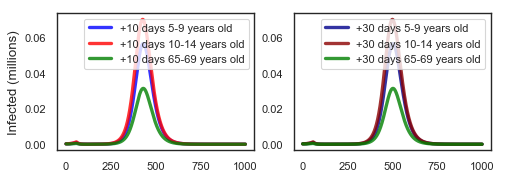

In [185]:
fig = plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 5})

color=['blue','red','green']
color1=['darkblue','darkred','green']
age = df3.Age.to_list()
plt.subplot(2,2,1)
for j,m in enumerate([1, 2 , 13]):
    plt.plot(t1, I1[:,m]*10**(-6), '-', lw=3, color=color[j], label='+10 days '+age[m]+' years old', alpha=0.8)
plt.legend(fontsize=10); 
plt.tick_params(axis='both', which='major', labelsize=10)

plt.ylabel('Infected (millions)', fontsize=12)
plt.subplot(2,2,2)
for j,m in enumerate([1, 2 , 13]):
    plt.plot(t2, I2[:,m]*10**(-6), '-', lw=3, color=color1[j], label='+30 days '+age[m]+' years old', alpha=0.8)

plt.legend(fontsize=10); 
plt.axis('tight')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('UK-forecastI1.png', format='png', dpi=200);

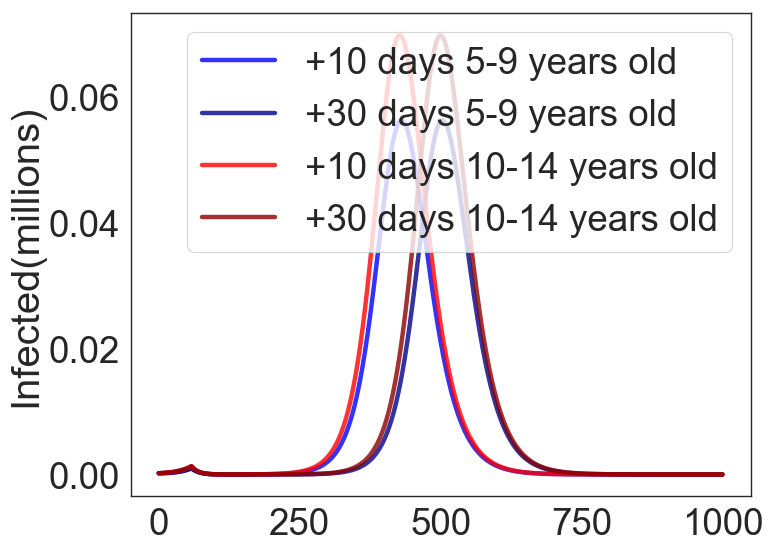

In [112]:
color=['blue','red']
color1=['darkblue','darkred']
age = df3.Age.to_list()
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

for j,m in enumerate([1, 2]):
    plt.plot(t1, I1[:,m]*10**(-6), '-', lw=4, color=color[j], label='+10 days '+age[m]+' years old', alpha=0.8)
    plt.plot(t2,I2[:,m]*10**(-6), '-', lw=4, color=color1[j], label='+30 days '+age[m]+' years old', alpha=0.8)

plt.ylabel('Infected(millions)')
plt.legend();

In [187]:
S1d = pd.DataFrame(S1, columns=df3.Age.to_list()[0:16])
I1d = pd.DataFrame(I1, columns=df3.Age.to_list()[0:16])
S2d = pd.DataFrame(S2, columns=df3.Age.to_list()[0:16])
I2d = pd.DataFrame(I2, columns=df3.Age.to_list()[0:16])
S3d = pd.DataFrame(S3, columns=df3.Age.to_list()[0:16])
I3d = pd.DataFrame(I3, columns=df3.Age.to_list()[0:16])

After the closure day, the total number of infected per category is the same for all closure periods. 

In [188]:
list_eld = ['60-64','65-69','70-74','75-79']
list_young =  ['0-4','5-9','10-14', '15-19']
day = dayopen1

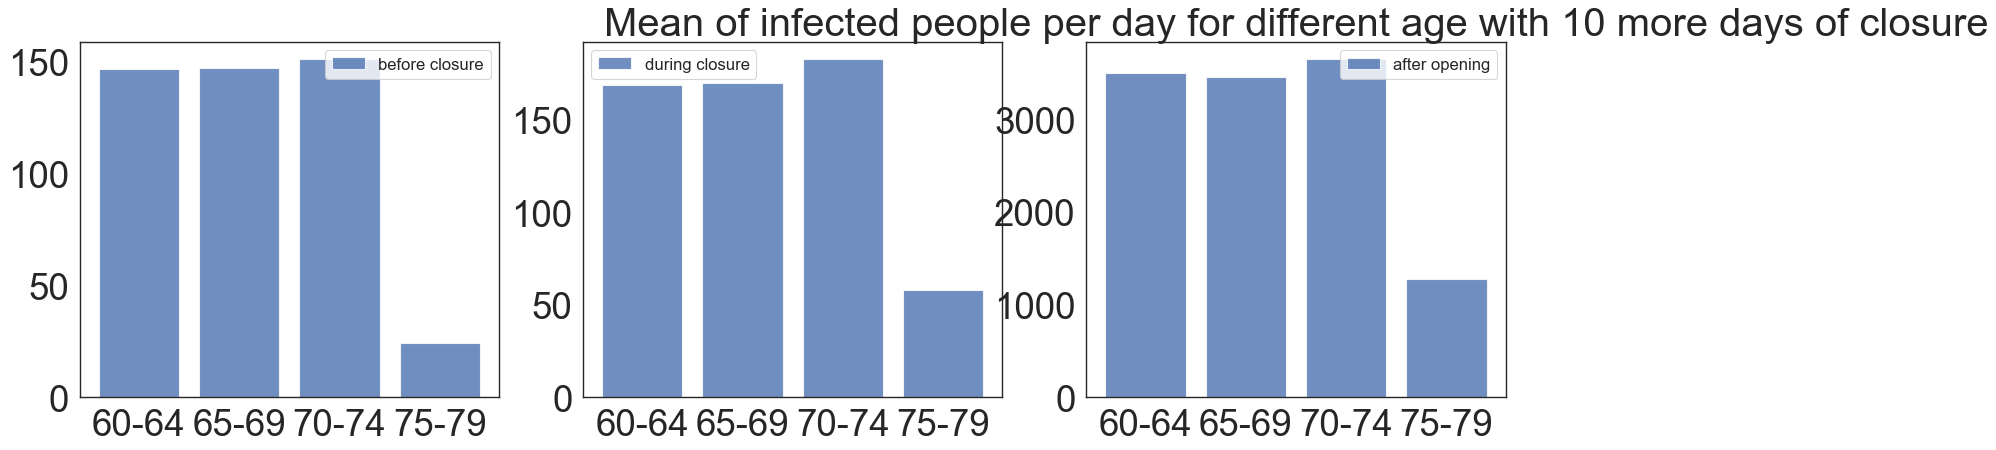

In [200]:
fig = plt.figure(num=None, figsize=(23, 20), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 5})
plt.subplot(3,3,1)
plt.bar(list_eld,I1d.loc[:dayclosure, list_eld].mean(axis=0), label='before closure', alpha=0.8);
plt.legend(fontsize=15);
plt.subplot(3,3,2)
plt.bar(list_eld,I1d.loc[dayclosure:day, list_eld].mean(axis=0),label='during closure', alpha=0.8);
plt.legend(fontsize=15);
plt.subplot(3,3,3)
plt.bar(list_eld,I1d.loc[day:, list_eld].mean(axis=0),   label='after opening', alpha=0.8);
plt.legend(fontsize=15); 
plt.axis('tight')

plt.title('Mean of infected people per day for different age with 10 more days of closure');
